In [14]:
import random
import numpy as np
import math
import mesa
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from mesa import Agent, Model
from mesa.time import BaseScheduler
from collections import deque
import pandas as pd
from SCN.agent import Order, Customer, Manufacturer, Supplier
from SCN.model import update_transport_cost_for_order, SupplyChainGridModel, calculate_unit_cost_window, calculate_ratio_window, haversine_km

In [15]:
df = pd.read_csv("SCN/supply_chain_data.csv")
df.rename(columns={"Stock levels": "inventory"}, inplace=True)
df["inventory"] = df["inventory"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df["Order quantities"] = df["Order quantities"].apply(lambda x: math.ceil(x) if pd.notnull(x) else x)
df = df[["inventory", "Order quantities"]]
inventory_count = df["inventory"].count()
order_qty_count = df["Order quantities"].count()
print("inventory 列数据个数（非空）:", inventory_count)
print("Order quantities 列数据个数（非空）:", order_qty_count)
print(df.head())
demands_list = df["Order quantities"].dropna().tolist()
inventory_list = df["inventory"].dropna().astype(int).tolist()
inventory_mean = df["inventory"].mean()
order_qty_mean = df["Order quantities"].mean()

print(f"Inventory 列的均值: {inventory_mean}")
print(f"Order quantities 列的均值: {order_qty_mean}")

inventory 列数据个数（非空）: 100
Order quantities 列数据个数（非空）: 100
   inventory  Order quantities
0         58                96
1         53                37
2          1                88
3         23                59
4          5                56
Inventory 列的均值: 47.77
Order quantities 列的均值: 49.22


In [16]:
import networkx as nx

def get_weighted_edge_count(model, win=50):
    """
    统计最近 win 步窗口内（含当前步）完成的产品订单，
    以订单数量为权重汇总边数。
    """
    window_begin = model.schedule.steps - win
    G = nx.MultiGraph()

    # 把所有代理作为节点加入
    for agent in model.schedule.agents:
        G.add_node(agent.unique_id)

    # 只考虑窗口内完成、已发货、且类型为 product 的订单
    for order in model.delivered_orders:
        if (order.order_type == "product"
            and order.completed
            and order.shipped
            and order.completed_step > window_begin):          # 直接用 completed_step
            G.add_edge(order.sender_id,
                       order.receiver_id,
                       weight=order.quantity)

    # 汇总权重
    total_weight = sum(data["weight"] for _, _, data in G.edges(data=True))
    return total_weight

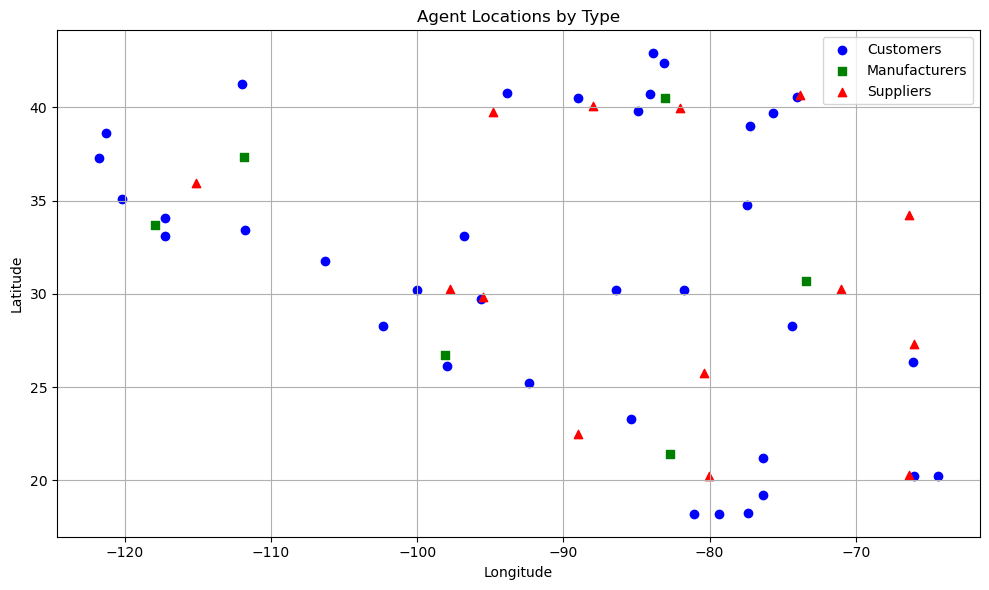

In [17]:
cust_pos = [
    (34.077606, -117.240181), (20.210739, -64.370605),  (38.611774, -121.282867),
    (26.145800, -97.958252),  (34.748348, -77.428482),  (40.763580, -93.830040),
    (23.285648, -85.370613),  (40.508579, -88.982643),  (40.575642, -73.995209),
    (33.089520, -117.255203), (19.228659, -76.370560),  (18.212404, -81.037056),
    (29.696537, -95.645920),  (39.000355, -77.227814),  (41.274368, -111.962868),
    (30.216906, -86.370514),  (30.223112, -100.037056),  (28.261724, -102.370583),
    (21.203922, -76.370613),  (20.253136, -66.037064),  (30.181829, -81.741158),
    (18.260290, -77.370575),  (39.827408, -84.890228),  (35.078728, -120.203323),
    (31.743509, -106.304138), (40.706020, -84.086853),  (25.223833, -92.370514),
    (37.287724, -121.764404), (18.223146, -79.370567),  (42.892185, -83.862381),
    (39.681881, -75.644211),  (42.391102, -83.131218),  (26.359011, -66.078171),
    (33.087120, -96.823570),  (33.410011, -111.771797), (28.268904, -74.370522)
]

man_pos = [
    (33.676708, -117.921905), (21.412319, -82.692352),
    (30.686657, -73.375534),  (40.513103, -83.021828),
    (26.697084, -98.124062),  (37.312534, -111.870071)
]

sup_pos = [
    (22.496193, -88.990883),  (30.258694, -97.766251),
    (40.675449, -73.811142),  (20.280403, -66.370575),
    (39.746620, -94.816437), (25.740225, -80.361694),
    (30.262302, -71.037056),  (29.827169, -95.501747),
    (20.224937, -80.037048),  (34.238966, -66.370621),
    (35.950428, -115.129326), (27.290588, -66.037064),
    (40.050499, -87.989975),  (39.941486, -82.002220),
]
def unpack_coords(positions):
    lat = [p[0] for p in positions]
    lon = [p[1] for p in positions]
    return lat, lon

cust_lat, cust_lon = unpack_coords(cust_pos)
man_lat,  man_lon  = unpack_coords(man_pos)
sup_lat,  sup_lon  = unpack_coords(sup_pos)

# 绘图
plt.figure(figsize=(10, 6))
plt.scatter(cust_lon, cust_lat, c='blue', marker='o', label='Customers')
plt.scatter(man_lon,  man_lat,  c='green', marker='s', label='Manufacturers')
plt.scatter(sup_lon,  sup_lat,  c='red', marker='^', label='Suppliers')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Agent Locations by Type")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


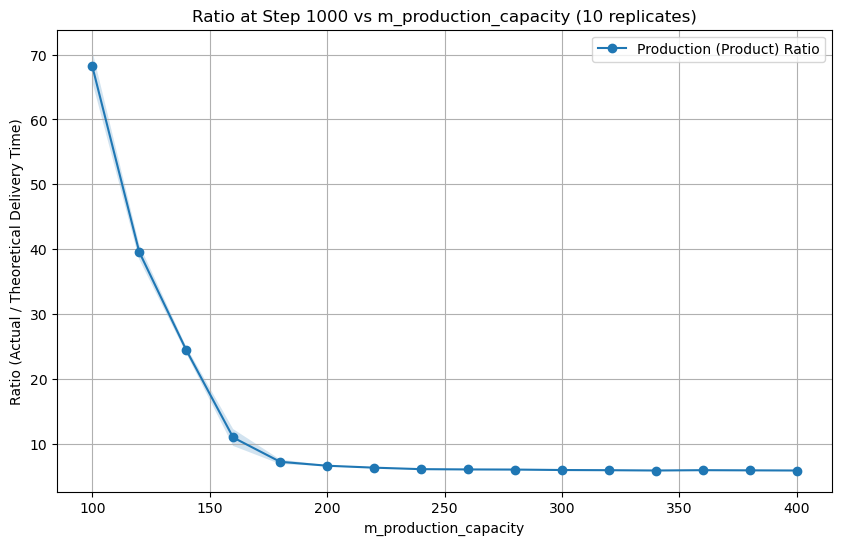

In [13]:
total_steps = 2000
num_replicates = 2
m_production_values = range(100,420,20)
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表
mat_results = []   # 每个 m_production_capacity 下的 material ratio 列表
for m_prod in m_production_values:
    prod_list = []
    mat_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=m_prod,
                 m_inventory_capacity_product=700,
                 m_inventory_capacity_material=1000,
                 s_material_capacity=200,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=1000,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=900,
                 rm_purchase_multiplier=1.2,
                 rm_produce_multiplier=1.2,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=6,
                 num_suppliers=14)
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else None
        prod_list.append(ratio_prod if ratio_prod is not None else 0)
    prod_results.append(prod_list)



# 计算均值和标准差
prod_means = [np.mean(x) for x in prod_results]
prod_stds = [np.std(x) for x in prod_results]

plt.figure(figsize=(10,6))
x = np.array(list(m_production_values))
prod_means = np.array(prod_means)
prod_stds = np.array(prod_stds)
plt.plot(x, prod_means, 'o-', label='Production (Product) Ratio')
plt.fill_between(x, prod_means - prod_stds, prod_means + prod_stds, alpha=0.2)
plt.xlabel('m_production_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs m_production_capacity (10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

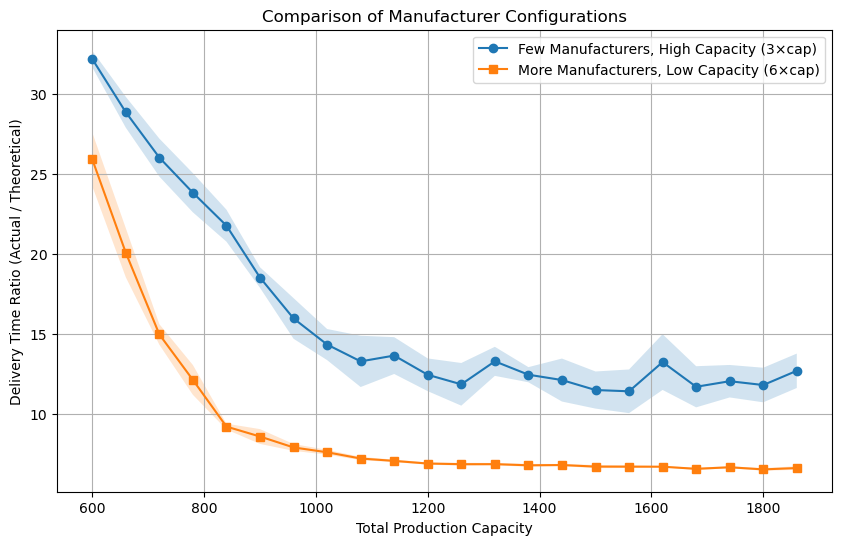

In [8]:
total_steps = 500
num_replicates = 5
prod_results_A = []  # Scenario A: few manufacturers, high capacity
prod_results_B = []  # Scenario B: more manufacturers, low capacity
total_capacities = []

# 设置匹配的单个产能值（保证总产能覆盖相同区间）
capacity_values_A = range(200, 640, 20)  # for 3 manufacturers
capacity_values_B = range(100, 320, 10)   # for 6 manufacturers

for cap_A, cap_B in zip(capacity_values_A, capacity_values_B):
    total_capacity = cap_A * 3  # or cap_B * 6，二者应相等
    total_capacities.append(total_capacity)

    prod_list_A = []
    prod_list_B = []

    # 情景 A：少量制造商，高产能
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=cap_A,
                 m_inventory_capacity_product=400,
                 m_inventory_capacity_material=800,
                 s_material_capacity=240,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=2.0,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=800,
                 rm_purchase_multiplier=1.5,
                 rm_produce_multiplier=1.5,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=3,
                 num_suppliers=14,
            # 其余参数略（与你已有代码一致）
        )
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time]
        ratio = sum(o.actual_delivery_time for o in prod_orders) / sum(o.theoretical_delivery_time for o in prod_orders)
        prod_list_A.append(ratio)

    # 情景 B：多个制造商，低产能
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            cust_positions=cust_pos,
                 man_positions=man_pos,
                 sup_positions=sup_pos,
                 demands_list=demands_list,
                 inventory_list=inventory_list,                 
                 cust_demand_multiplier=1.0,
                 m_production_capacity=cap_B,
                 m_inventory_capacity_product=400,
                 m_inventory_capacity_material=800,
                 s_material_capacity=240,
                 agent_mode="homogeneous",  # 这里可以选择 "heterogeneous" 或其他模式
                 logistics_speed=2.0,
                 rm_procurement_mode="gap_based",
                 rm_reorder_point=400,
                 rm_reorder_target=800,
                 rm_purchase_multiplier=1.5,
                 rm_produce_multiplier=1.5,
                 product_order_mode="normal",
                 material_order_mode="normal",
                 num_customers=36,
                 num_manufacturers=6,
                 num_suppliers=14
            # 其余参数略
        )
        for t in range(1, total_steps+1):
            model.step()
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time]
        ratio = sum(o.actual_delivery_time for o in prod_orders) / sum(o.theoretical_delivery_time for o in prod_orders)
        prod_list_B.append(ratio)

    prod_results_A.append(prod_list_A)
    prod_results_B.append(prod_list_B)

# 计算均值和标准差
means_A = [np.mean(x) for x in prod_results_A]
stds_A  = [np.std(x) for x in prod_results_A]
means_B = [np.mean(x) for x in prod_results_B]
stds_B  = [np.std(x) for x in prod_results_B]

# 绘图
x = np.array(total_capacities)
plt.figure(figsize=(10,6))
plt.plot(x, means_A, 'o-', label='Few Manufacturers, High Capacity (3×cap)')
plt.fill_between(x, np.array(means_A)-np.array(stds_A), np.array(means_A)+np.array(stds_A), alpha=0.2)

plt.plot(x, means_B, 's-', label='More Manufacturers, Low Capacity (6×cap)')
plt.fill_between(x, np.array(means_B)-np.array(stds_B), np.array(means_B)+np.array(stds_B), alpha=0.2)

plt.xlabel('Total Production Capacity')
plt.ylabel('Delivery Time Ratio (Actual / Theoretical)')
plt.title('Comparison of Manufacturer Configurations')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
s_material_capacity = 400  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=s_material_capacity,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=1.1,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(s_material_capacity*num_suppliers)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/s_material_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Material Capacity Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


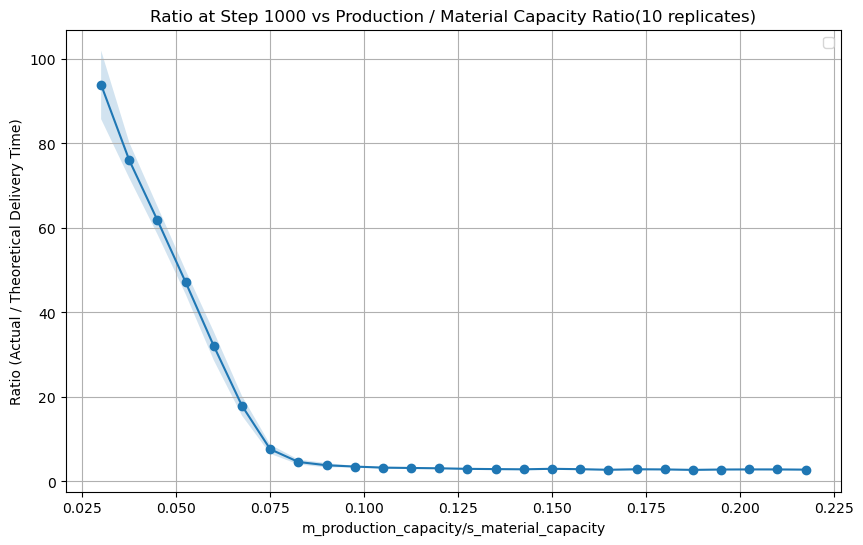

In [26]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
s_material_capacity = 1000  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=s_material_capacity,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=1.1,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(s_material_capacity*num_suppliers)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/s_material_capacity')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Material Capacity Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


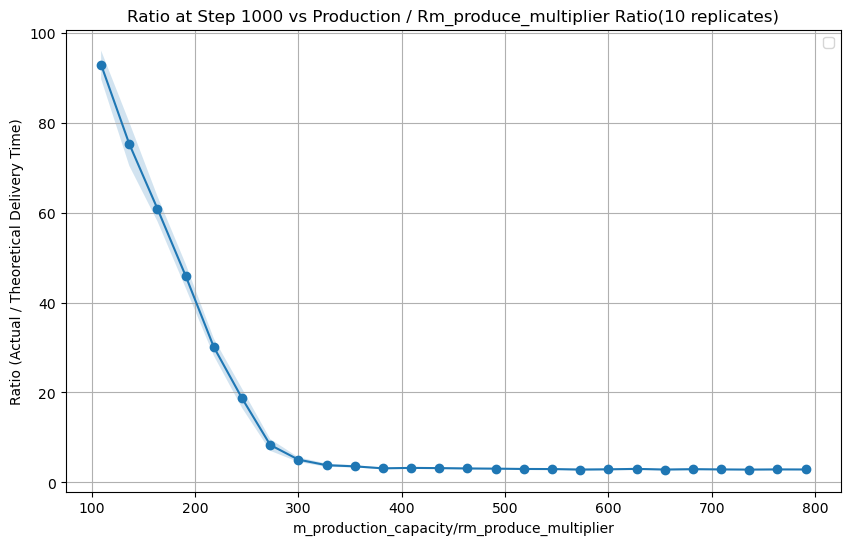

In [28]:
total_steps = 1000
num_replicates = 10
m_production_values = range(20,150,5)
rm_produce_multiplier = 1.1  # 你的固定物料能力
num_manufacturers=6
num_suppliers=4
prod_results = []  # 每个 m_production_capacity 下的 product ratio 列表

for m_prod in m_production_values:
    prod_list = []
    for rep in range(num_replicates):
        model = SupplyChainGridModel(
            positions=positions,
            demands_list=demands_list,
            inventory_list=inventory_list,                 
            cust_demand_multiplier=1.0,
            m_production_capacity=m_prod,
            m_inventory_capacity_product=300,
            m_inventory_capacity_material=600,
            s_material_capacity=400,
            m_cap_mode="homogeneous",
            logistics_speed=2.0,
            rm_procurement_mode="gap_based",
            rm_reorder_point=300,
            rm_reorder_target=600,
            rm_purchase_multiplier=1.1,
            rm_produce_multiplier=rm_produce_multiplier,
            product_order_mode="normal",
            material_order_mode="normal",
            num_customers=20,
            num_manufacturers=6,
            num_suppliers=4
        )
        for t in range(1, total_steps+1):
            model.step()
        # 统计 delivered_orders 中的 product
        prod_orders = [
            o for o in model.delivered_orders
            if o.order_type=="product" and o.actual_delivery_time is not None
        ]
        sum_actual = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual / sum_theoretical if sum_theoretical>0 else 0
        prod_list.append(ratio_prod)
    prod_results.append(prod_list)

# 计算均值和标准差
prod_means = np.array([np.mean(lst) for lst in prod_results])
prod_stds  = np.array([np.std(lst)  for lst in prod_results])

# 这里算出“生产能力/物料能力”的比值
ratio_vals = np.array([(m_prod*num_manufacturers)/(rm_produce_multiplier)for m_prod in m_production_values])

plt.figure(figsize=(10,6))
plt.plot(ratio_vals, prod_means, 'o-')
plt.fill_between(ratio_vals,
                 prod_means - prod_stds,
                 prod_means + prod_stds,
                 alpha=0.2)
plt.xlabel('m_production_capacity/rm_produce_multiplier')
plt.ylabel('Ratio (Actual / Theoretical Delivery Time)')
plt.title('Ratio at Step 1000 vs Production / Rm_produce_multiplier Ratio(10 replicates)')
plt.legend()
plt.grid(True)
plt.show()

Scan m_prod: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [29:36<00:00, 88.81s/it]


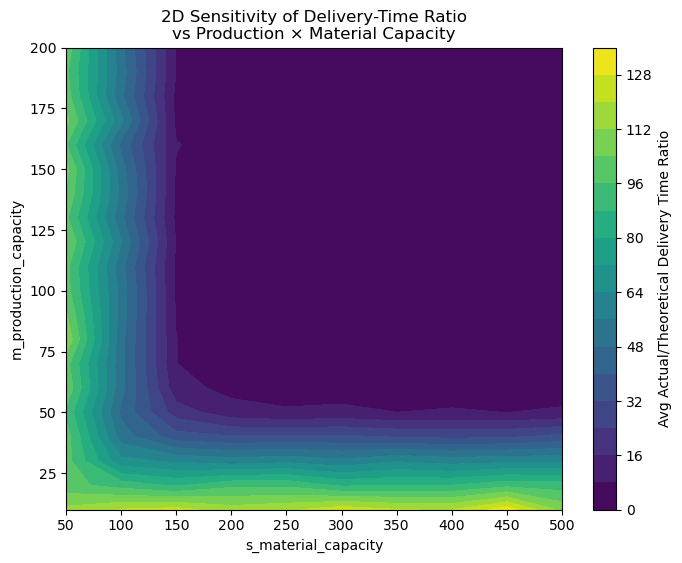

In [23]:
from tqdm import tqdm
TOTAL_STEPS     = 1000
NUM_REPLICATES  = 2
NUM_SUPPLIERS   = 4
NUM_MANUFACTURERS = 6

# 扫描范围
m_vals = np.arange(10, 201, 10)   # 生产能力 从 10 到 200，每 10 一步
s_vals = np.arange(50, 501, 50)   # 物料能力 从 50 到 500，每 50 一步

results = np.zeros((len(m_vals), len(s_vals)))

# 双重循环
for i, m_prod in enumerate(tqdm(m_vals, desc="Scan m_prod")):
    for j, s_mat in enumerate(tqdm(s_vals, desc="Scan s_mat", leave=False)):
        ratios = []
        for rep in range(NUM_REPLICATES):
            model = SupplyChainGridModel(
                positions=positions,
                demands_list=demands_list,
                inventory_list=inventory_list,
                cust_demand_multiplier=1.0,
                m_production_capacity=m_prod,
                m_inventory_capacity_product=300,
                m_inventory_capacity_material=600,
                s_material_capacity=s_mat,
                m_cap_mode="homogeneous",
                logistics_speed=2.0,
                rm_procurement_mode="gap_based",
                rm_reorder_point=300,
                rm_reorder_target=600,
                rm_purchase_multiplier=1.1,
                rm_produce_multiplier=1.1,
                product_order_mode="normal",
                material_order_mode="normal",
                num_customers=20,
                num_manufacturers=NUM_MANUFACTURERS,
                num_suppliers=NUM_SUPPLIERS
            )
            # 运行若干步
            for _ in range(TOTAL_STEPS):
                model.step()

            # 收集所有已完成的“产品”订单
            prod_orders = [
                o for o in model.delivered_orders
                if o.order_type=="product" and o.actual_delivery_time is not None
            ]
            actual   = sum(o.actual_delivery_time   for o in prod_orders)
            theoretical = sum(o.theoretical_delivery_time for o in prod_orders)
            ratio = (actual / theoretical) if theoretical>0 else 0
            ratios.append(ratio)

        results[i, j] = np.mean(ratios)
        
# 绘制等高线填色图
X, Y = np.meshgrid(s_vals, m_vals)  # X 轴：s_material_capacity, Y 轴：m_production_capacity

plt.figure(figsize=(8,6))
cp = plt.contourf(X, Y, results, levels=20, cmap="viridis")
plt.colorbar(cp, label="Avg Actual/Theoretical Delivery Time Ratio")
plt.xlabel("s_material_capacity")
plt.ylabel("m_production_capacity")
plt.title("2D Sensitivity of Delivery‐Time Ratio\nvs Production × Material Capacity")
plt.show()

In [ ]:
def run_simulation(heterogeneous=False, m_prod_value=None, total_steps=1000, num_reps=5):
    """
    若 heterogeneous==False，则采用 uniform 模式，m_prod_value为统一生产能力；
    若 heterogeneous==True，则每个manufacturer随机取值于 [m_prod_value-5, m_prod_value+5]。
    返回：均值、产品订单ratio、原材料订单ratio、制造商状态N的累计频次。
    """
    ratio_prod_list = []
    ratio_mat_list = []
    statusN_freq_list = []
    capacity_means = []
    for rep in range(num_reps):
        used_positions.clear()
        if heterogeneous:
            model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=m_prod,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=True)
            caps = [m.production_capacity for m in model.manufacturers]
            capacity_means.append(np.mean(caps))
        else:
            model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=m_prod,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=False)
            capacity_means.append(m_prod_value)
        statusN_freq = 0
        for t in range(1, total_steps+1):
            model.step()
            statusN_freq += sum(1 for m in model.manufacturers if m.status == 'N')
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else 0
        ratio_prod_list.append(ratio_prod)
        statusN_freq_list.append(statusN_freq)
    return np.mean(capacity_means), np.mean(ratio_prod_list), np.mean(statusN_freq_list)

# 对于 uniform 模式，m_prod_value 取 5~30 的每个整数
uniform_targets = list(range(5, 30))
uni_caps = []
uni_prod_ratios = []
uni_mat_ratios = []
uni_statusN = []

for m_prod in uniform_targets:
    cap_mean, rprod, statusN = run_simulation(heterogeneous=False, m_prod_value=m_prod, total_steps=1000, num_reps=10)
    uni_caps.append(cap_mean)
    uni_prod_ratios.append(rprod)
    uni_statusN.append(statusN)
    print(f"Uniform m_prod = {m_prod}: cap_mean={cap_mean}, prod ratio={rprod}, status N freq={statusN}")

# 对于 heterogeneous 模式，目标均值取 5~16，每个 manufacturer 随机取值于 [target-5, target+5]
hetero_caps = []
hetero_prod_ratios = []
hetero_statusN = []

for target in uniform_targets:
    reps = 10
    hetero_prod_list = []
    hetero_statusN_list = []
    caps_list = []
    for rep in range(reps):
        used_positions.clear()
        # 对每个 manufacturer，随机取值于 [target-5, target+5]
        num_manufacturers = 6
        manufacturers_caps = [random.randint(max(1, target-10), target+10) for _ in range(num_manufacturers)]
        model = SupplyChainGridModel(positions,             
                 demands_list,          
                 inventory_list,        
                 num_customers=10,
                 num_manufacturers=6,
                 num_suppliers=2,
                 cust_demand_probability=0.4,
                 m_production_capacity=target,
                 m_inventory_capacity=1000,
                 s_material_capacity=300, heterogeneous=False)
        # 替换每个 Manufacturer 的生产能力为随机值
        for i, m in enumerate(model.manufacturers):
            m.production_capacity = manufacturers_caps[i]
        caps_list.append(np.mean(manufacturers_caps))
        statusN_freq = 0
        for t in range(1, 1000+1):
            model.step()
            statusN_freq += sum(1 for m in model.manufacturers if m.status == 'N')
        prod_orders = [o for o in model.delivered_orders if o.order_type == "product" and o.actual_delivery_time is not None]
        sum_actual_prod = sum(o.actual_delivery_time for o in prod_orders)
        sum_theoretical_prod = sum(o.theoretical_delivery_time for o in prod_orders)
        ratio_prod = sum_actual_prod / sum_theoretical_prod if sum_theoretical_prod > 0 else 0
        hetero_prod_list.append(ratio_prod)
        hetero_statusN_list.append(statusN_freq)
    hetero_caps.append(np.mean(caps_list))
    hetero_prod_ratios.append(np.mean(hetero_prod_list))
    hetero_statusN.append(np.mean(hetero_statusN_list))
    print(f"Hetero target = {target}: cap_mean={np.mean(caps_list):.2f}, prod ratio={np.mean(hetero_prod_list):.3f}, status N freq={np.mean(hetero_statusN_list):.1f}")

# 绘制比值图
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
x = np.array(uniform_targets)
plt.errorbar(x, uni_prod_ratios, fmt='o-', label='Uniform Product Ratio')
plt.errorbar(x, hetero_prod_ratios, fmt='o--', label='Hetero Product Ratio')
plt.xlabel('Mean Production Capacity')
plt.ylabel('Ratio (Actual/Theoretical Delivery Time)')
plt.title('Ratio at Step 1000')
plt.legend()
plt.grid(True)

# 绘制状态 N 频次图
plt.subplot(1,2,2)
plt.plot(x, uni_statusN, 'o-', label='Uniform Mode')
plt.plot(x, hetero_statusN, 's--', label='Hetero Mode')
plt.xlabel('Mean Production Capacity')
plt.ylabel('Accumulated Manufacturer N Frequency (1000 steps)')
plt.title('Manufacturer Status N Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()